![Сбор данных](https://ptzgovorit.ru/sites/default/files/original_nodes/banka_tasima_7.jpg)

# Содержание

- [1. Библиотеки](#1.-Библиотеки)
- [2. Загрузка и просмотр данных](#2.-Загрузка-и-просмотр-данных)
- [3. Предобработка ряда](#3.-Предобработка-ряда)
- [4. Моделирование](#4.-Моделирование)
    * [4.1 Наивное моделирование](#4.1-Наивное-моделирование)
    * [4.2 Ранжирование дефолтных моделей](#4.2-Ранжирование-дефолтных-моделей)
    * [4.3 Поиск лучших гиперпараметров](#4.3-Поиск-лучших-гиперпараметров)
    * [4.4 Стекинг алгоритмов](#4.4-Стекинг-алгоритмов)
    * [4.5 Формирование файла Submission](#4.5-Формирование-файла-Submission)

# 1. Библиотеки

In [66]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline

# 2. Загрузка и просмотр данных

In [67]:
sb = pd.read_csv('C:/Users/Алексей Третьяков/Desktop/ML_projects/FierceDra-X.github.io/Sber/data.csv', sep = ';')

In [68]:
sb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   REPORTDATE  2111 non-null   object
 1   VALUE       2111 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 33.1+ KB


In [69]:
sb.isna().sum()

REPORTDATE    0
VALUE         0
dtype: int64

In [70]:
sb.head(5)

,REPORTDATE,VALUE
0,30.12.2013,3457625638
1,31.12.2013,3417092149
2,01.01.2014,3417092149
3,02.01.2014,3417092149
4,03.01.2014,3417092149


# 3. Предобработка ряда

In [71]:
#переименуем колонки
new_columns = ['date', 'value']
sb.columns = new_columns

#переведем строковые переменные в колонке date в формат datetime
sb['date'] = pd.to_datetime(sb['date'], format = '%d.%m.%Y')
sb.head()

,date,value
0,2013-12-30,3457625638
1,2013-12-31,3417092149
2,2014-01-01,3417092149
3,2014-01-02,3417092149
4,2014-01-03,3417092149


In [72]:
#колонку с остатками средств клиентов приведем к размеру млн. рублей
sb['value'] = sb['value'].values/1000000
sb.sample(5)

,date,value
1734,2018-09-29,48724.197657
632,2015-09-23,17035.858779
684,2015-11-14,21149.322358
1440,2017-12-09,45203.497607
1950,2019-05-03,63323.831679


# 4. Визуальный анализ ряда

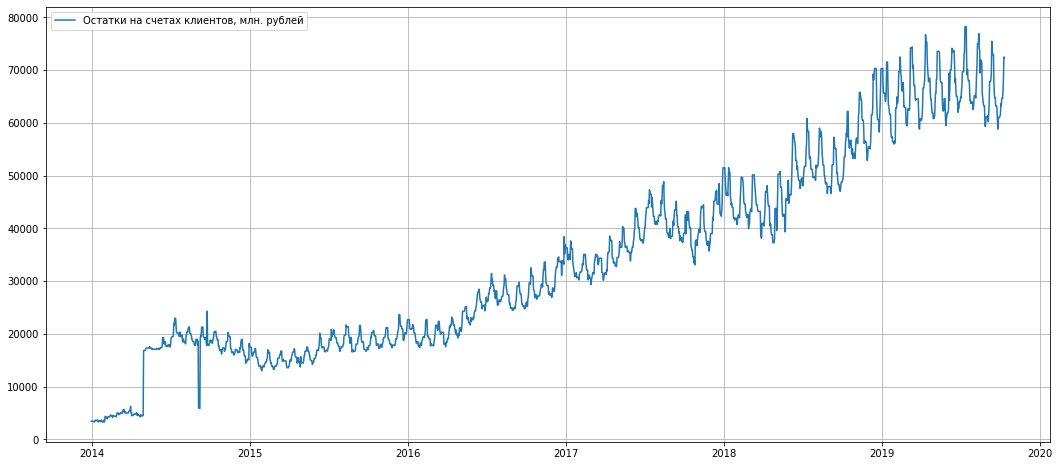

In [80]:
## визуализируем
f, ax = plt.subplots(1, 1, figsize=(18, 8))

ax.plot(sb.date, sb.value)
ax.legend(['Остатки на счетах клиентов, млн. рублей'])
ax.grid()

> * ряд имеет явный тренд роста, который меняет направление в 2019-2020 годах
> * еще видны регулярные колебание, посмотрим на них в более коротких отрезках времени

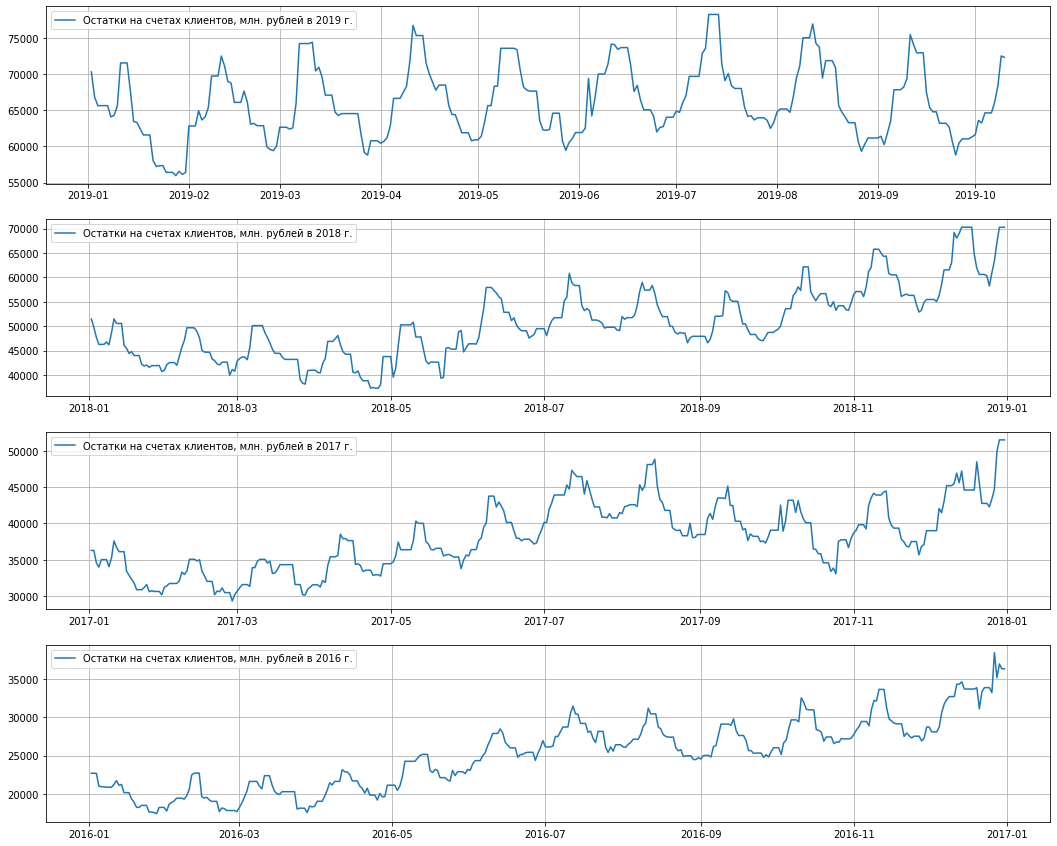

In [89]:
sb_2019 = sb[sb.date > '2019-01-01']

f, ax = plt.subplots(4, 1, figsize=(18, 15))

ax[0].plot(sb[sb.date > '2019-01-01'].date, sb[sb.date > '2019-01-01'].value) 
ax[0].legend(['Остатки на счетах клиентов, млн. рублей в 2019 г.'])
ax[0].grid()

ax[1].plot(sb[(sb.date > '2018-01-01') & (sb.date < '2019-01-01')].date,
           sb[(sb.date > '2018-01-01') & (sb.date < '2019-01-01')].value) 
ax[1].legend(['Остатки на счетах клиентов, млн. рублей в 2018 г.'])
ax[1].grid()

ax[2].plot(sb[(sb.date > '2017-01-01') & (sb.date < '2018-01-01')].date,
           sb[(sb.date > '2017-01-01') & (sb.date < '2018-01-01')].value) 
ax[2].legend(['Остатки на счетах клиентов, млн. рублей в 2017 г.'])
ax[2].grid()

ax[3].plot(sb[(sb.date > '2016-01-01') & (sb.date < '2017-01-01')].date,
           sb[(sb.date > '2016-01-01') & (sb.date < '2017-01-01')].value) 
ax[3].legend(['Остатки на счетах клиентов, млн. рублей в 2016 г.'])
ax[3].grid()

> * остатки явно испытывают месячные колебания
> * минимумы приходятся на конец месяца, максимумы на район 10-ого числа месяца
> * скорее всего, это влияние цикличности в выплатах заработной платы